<a href="https://colab.research.google.com/github/quiidich/3-min-pytorch/blob/master/Burgers_Eq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from random import uniform
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

iter = 0

In [15]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [16]:
class BurgersNN(nn.Module):
    def __init__(self,):
        super(BurgersNN, self).__init__()
        self.linear_in = nn.Linear(2, 20)
        self.linear_out = nn.Linear(20, 1)
        self.layers = nn.ModuleList([nn.Linear(20, 20) for i in range(8)])
        self.act = nn.Tanh()

    def forward(self, x):
        x = self.linear_in(x)
        x = self.act(x)
        for layer in self.layers:
            x = self.act(layer(x))
        x = self.linear_out(x)
        return x

SyntaxError: expected ':' (<ipython-input-16-803c85c0e200>, line 9)

In [ ]:
def derivative(dy, x, order):
    for i in range(order):
        dy = torch.autograd.grad(
            dy, x, grad_outputs = torch.ones_like(dy), create_graph=True, retain_graph=True)[0]
    return dy

In [ ]:
def u_function(model, x, t):
    model_input = torch.stack((x, t), axis = 1)
    return model(model_input)

In [ ]:
def f(model, x_f, t_f):
    u = u_function(model, x_f, t_f)
    u_t = derivative(u, t_f, order=1)
    u_x = derivative(u, x_f, order=1)
    u_xx = derivative(u, x_f, order=2)
    f = u_t + u.T*u_x - (0.01/np.pi)*u_xx
    return f

In [ ]:
def loss_function(model, x_u, x_f, t_f, t_u, y_u):
    u = u_function(model, x_f, t_f)
    MSE_f = f(model, x_f, t_f).pow(2).mean()
    MSE_u = (u_function(model, x_u, t_u)-y_u).pow(2).mean()
    return MSE_f + MSE_u

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
def closure(model, optimizer, X_u_train, X_f_train, Y_u_train):
    x_u = X_u_train[:, 0]
    t_u = X_u_train[:, 1]
    x_f = X_f_train[:, 0]
    t_f = X_f_train[:, 1]
    y_u = Y_u_train
    optimizer.zero_grad()
    loss = loss_function(model, x_u, x_f, t_f, t_u, y_u)
    loss.backward()
    global iter
    iter += 1
    if iter % 100 == 0:
       print(f" iteration: {iter}  loss: {loss.item()}")
    return loss

In [ ]:
def train(model, X_u_train, X_f_train, u_train):
    # Initialize the optimizer
    optimizer = torch.optim.LBFGS(model.parameters(),
                                    lr=1,
                                    max_iter=50000,
                                    max_eval=50000,
                                    history_size=50,
                                    tolerance_grad=1e-05,
                                    tolerance_change=0.5 * np.finfo(float).eps,
                                    line_search_fn="strong_wolfe")

    # the optimizer.step requires the closure function to be a callable function without inputs
    # therefore we need to define a partial function and pass it to the optimizer
    closure_fn = partial(closure, model, optimizer, X_u_train, X_f_train, u_train)
    optimizer.step(closure_fn)

In [ ]:
if __name__ == "__main__":
    # Set seed for reproducibility
    set_seed(42)

    nu = 0.01 / np.pi         # constant in the diff. equation
    N_u = 100                 # number of data points in the boundaries
    N_f = 10000               # number of collocation points

    # X_u_train: a set of pairs (x, t) located at:
        # x =  1, t = [0,  1]
        # x = -1, t = [0,  1]
        # t =  0, x = [-1, 1]
    x_upper = np.ones((N_u//4, 1), dtype=float)
    x_lower = np.ones((N_u//4, 1), dtype=float) * (-1)
    t_zero = np.zeros((N_u//2, 1), dtype=float)

    t_upper = np.random.rand(N_u//4, 1)
    t_lower = np.random.rand(N_u//4, 1)
    x_zero = (-1) + np.random.rand(N_u//2, 1) * (1 - (-1))

    # stack uppers, lowers and zeros:
    X_upper = np.hstack( (x_upper, t_upper) )
    X_lower = np.hstack( (x_lower, t_lower) )
    X_zero = np.hstack( (x_zero, t_zero) )

    # each one of these three arrays haS 2 columns,
    # now we stack them vertically, the resulting array will also have 2
    # columns and 100 rows:
    X_u_train = np.vstack( (X_upper, X_lower, X_zero) )

    # shuffle X_u_train:
    index = np.arange(0, N_u)
    np.random.shuffle(index)
    X_u_train = X_u_train[index, :]

    # make X_f_train:
    X_f_train = np.zeros((N_f, 2), dtype=float)
    for row in range(N_f):
        x = uniform(-1, 1)  # x range
        t = uniform( 0, 1)  # t range

        X_f_train[row, 0] = x
        X_f_train[row, 1] = t

    # add the boundary points to the collocation points:
    X_f_train = np.vstack( (X_f_train, X_u_train) )

    # make u_train
    u_upper =  np.zeros((N_u//4, 1), dtype=float)
    u_lower =  np.zeros((N_u//4, 1), dtype=float)
    u_zero = -np.sin(np.pi * x_zero)

    # stack them in the same order as X_u_train was stacked:
    u_train = np.vstack( (u_upper, u_lower, u_zero) )

    # match indices with X_u_train
    u_train = u_train[index, :]
    # Model instantiation
    model = BurgersNN()
    model.apply(init_weights)
    # Training
    X_u_train = torch.from_numpy(X_u_train).requires_grad_(True).float()
    X_f_train = torch.from_numpy(X_f_train).requires_grad_(True).float()
    u_train = torch.from_numpy(u_train).requires_grad_(True).float()

    model.train()
    train(model, X_u_train, X_f_train, u_train)
    # save the model
#    torch.save(model.state_dict(), 'Burgers_Equation/models/model_LBFGS_shuffle_normal.pt')


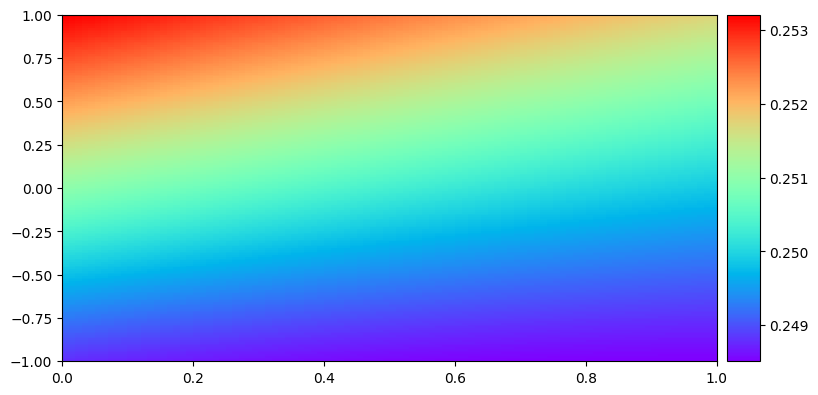

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# load model
model = BurgersNN()
#model.load_state_dict(torch.load('Burgers_Equation/models/model_LBFGS_shuffle_normal.pt'))
x = torch.linspace(-1, 1, 200)
t = torch.linspace( 0, 1, 100)

# x & t grids:
X, T = torch.meshgrid(x, t)

# x & t columns:
xcol = X.reshape(-1, 1)
tcol = T.reshape(-1, 1)
input = torch.cat((xcol, tcol), 1)
# one large column:
usol = model(input)

# reshape solution:
U = usol.reshape(x.numel(), t.numel())

# transform to numpy:
xnp = x.numpy()
tnp = t.numpy()
Unp = U.detach().numpy()

# plot:
fig = plt.figure(figsize=(9, 4.5))
ax = fig.add_subplot(111)

h = ax.imshow(Unp,
                interpolation='nearest',
                cmap='rainbow',
                extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()],
                origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=10)
plt.show()